## Running experiments for May6th meeting

In [1]:
from deep_rl import *
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import trange, tqdm
import random
import numpy as np
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

/home/surya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/surya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/surya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/surya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

In [36]:
def dqn_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: VanillaNet(config.action_dim, FCBody(config.state_dim, hidden_units=(16,)))
    # config.network_fn = lambda: DuelingNet(config.action_dim, FCBody(config.state_dim))
    # config.replay_fn = lambda: Replay(memory_size=int(1e4), batch_size=10)
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 1e4)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 5e4
    config.async_actor = False
    agent = DQNAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
            pass
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()
    return agent

In [3]:
def runNAgents(function, runs, store=False, freeze=0, ref=None):
    r_dqn = []; t_dqn = []
    if(store):
        agents = []
    for i in trange(runs, desc='runs'): 
        agent = function(game='FourRooms-Goal-9', freeze=freeze, ref=ref)
        rewards = np.array(agent.returns)
        t_dqn.append(rewards[:,0])
        r_dqn.append(rewards[:,1])
        if(store):
            agents.append(agent)
            
    if(store):
        return agents, t_dqn, r_dqn
    
    return t_dqn, r_dqn

In [4]:
class DQN():
    def __init__(self, weights_loc, game='FourRooms-Goal-9'):
        config = Config()
        config.game = game
        config.task_fn = lambda: Task(config.game)
        config.eval_env = config.task_fn()
        self.network = VanillaNet(config.action_dim, FCBody(config.state_dim, hidden_units=(416,)))
        self.network.load_state_dict(torch.load(weights_loc))
    
agents = []
for i in tqdm(range(104)):
    agents.append(DQN('storage/DQN-FourRooms-Goal-'+str(i)+'.weights'))

In [5]:
def avdsr_feature(**kwargs):
    kwargs['tag'] = 'Training avDSR based on DQN agents'
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim), hidden_units=()) #CHECK
    config.replay_fn = lambda: Replay(memory_size=int(1e5), batch_size=10)

    config.random_action_prob = LinearSchedule(0.8, 0.8, 1e4) # CHECK
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.max_steps = 2e5
    config.async_actor = False
    
    agent = avDSRAgent(config, config.agents, style='DQN')
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.log_interval and not agent.total_steps % config.log_interval:
            agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()

In [9]:
room_centers = [22, 38, 75, 91]
# room_centers = [22, 75, 91]
center_agents = []
for i in room_centers:
    center_agents.append(agents[i])

In [22]:
termState = np.random.randint(104)
game = 'FourRooms-Goal-' + str(termState)
print(game)
avdsr = avdsr_feature(game=game, agents=center_agents, choice=1)

2020-05-18 20:13:53,626 - root - INFO: steps 0, 199728761.90 steps/s


FourRooms-Goal-84


2020-05-18 20:13:54,878 - root - INFO: steps 1000, 799.43 steps/s
2020-05-18 20:13:56,006 - root - INFO: steps 2000, 888.68 steps/s
2020-05-18 20:13:57,123 - root - INFO: steps 3000, 896.12 steps/s
2020-05-18 20:13:58,379 - root - INFO: steps 4000, 797.80 steps/s
2020-05-18 20:13:59,597 - root - INFO: steps 5000, 822.39 steps/s
2020-05-18 20:14:00,824 - root - INFO: steps 6000, 816.28 steps/s
2020-05-18 20:14:02,215 - root - INFO: steps 7000, 719.86 steps/s
2020-05-18 20:14:03,485 - root - INFO: steps 8000, 790.17 steps/s
2020-05-18 20:14:04,810 - root - INFO: steps 9000, 755.72 steps/s
2020-05-18 20:14:05,951 - root - INFO: steps 10000, 877.11 steps/s
2020-05-18 20:14:07,143 - root - INFO: steps 11000, 839.74 steps/s
2020-05-18 20:14:08,621 - root - INFO: steps 12000, 677.66 steps/s
2020-05-18 20:14:10,204 - root - INFO: steps 13000, 632.36 steps/s
2020-05-18 20:14:11,444 - root - INFO: steps 14000, 807.38 steps/s
2020-05-18 20:14:12,609 - root - INFO: steps 15000, 863.13 steps/s
2020

2020-05-18 20:17:24,226 - root - INFO: steps 124000, 455.68 steps/s
2020-05-18 20:17:25,686 - root - INFO: steps 125000, 687.29 steps/s
2020-05-18 20:17:26,996 - root - INFO: steps 126000, 764.50 steps/s
2020-05-18 20:17:28,429 - root - INFO: steps 127000, 698.97 steps/s
2020-05-18 20:17:29,798 - root - INFO: steps 128000, 730.88 steps/s
2020-05-18 20:17:31,181 - root - INFO: steps 129000, 724.15 steps/s
2020-05-18 20:17:32,908 - root - INFO: steps 130000, 579.29 steps/s
2020-05-18 20:17:34,644 - root - INFO: steps 131000, 578.25 steps/s
2020-05-18 20:17:36,415 - root - INFO: steps 132000, 565.15 steps/s
2020-05-18 20:17:38,037 - root - INFO: steps 133000, 617.30 steps/s
2020-05-18 20:17:39,538 - root - INFO: steps 134000, 666.95 steps/s
2020-05-18 20:17:41,086 - root - INFO: steps 135000, 647.14 steps/s
2020-05-18 20:17:42,683 - root - INFO: steps 136000, 626.80 steps/s
2020-05-18 20:17:44,175 - root - INFO: steps 137000, 670.80 steps/s
2020-05-18 20:17:46,163 - root - INFO: steps 138

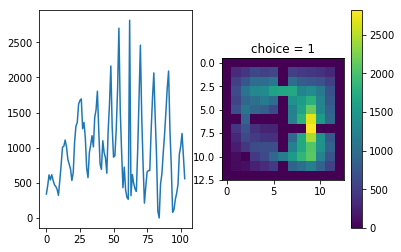

1


In [24]:
state = np.zeros(len(avdsr.replay.data))
for i in range(len(avdsr.replay.data)):
    state[i] = np.argmax(avdsr.replay.data[i][0])
counts = np.zeros(104)
for i in range(len(avdsr.replay.data)):
    counts[int(state[i])] += 1
plt.subplot(121)
plt.plot(counts)
plt.subplot(122)
visualize_vector(counts, title='choice = '+str(avdsr.choice))
print(avdsr.choice)

In [25]:
len(avdsr.actor.agents)

4

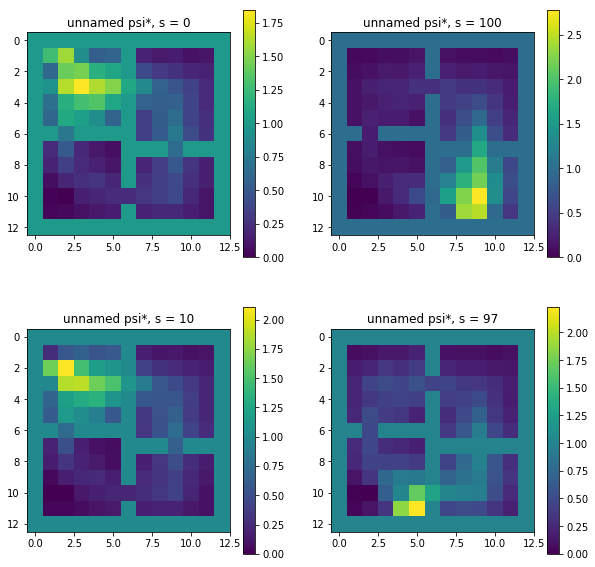

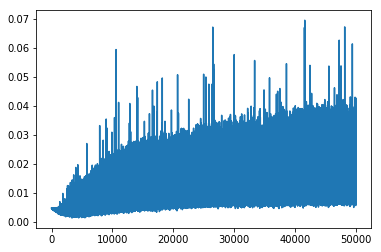

In [26]:
sanity_psi(avdsr)
plt.show()
plt.plot(avdsr.loss_vec)

In [27]:
def dsr_feature_init(ref,**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim))
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 1e3)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 5e4
    config.async_actor = False
    
    agent = DSRAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    if(ref is not None):
        agent.network.load_state_dict(ref.network.state_dict())
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
#             agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
#         import pdb; pdb.set_trace()
        agent.step()
        agent.switch_task()
        
    return agent

def dqn_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: VanillaNet(config.action_dim, FCBody(config.state_dim, hidden_units=(416,)))
    # config.network_fn = lambda: DuelingNet(config.action_dim, FCBody(config.state_dim))
    # config.replay_fn = lambda: Replay(memory_size=int(1e4), batch_size=10)
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 1e3)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 5e4
    config.async_actor = False
    agent = DQNAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
            pass
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()
    return agent

In [37]:
# r_dsr_init_dqns = runNAgents(dsr_feature_init, runs=1, freeze=2, ref=avdsr) 
# r_dsr_init_rand = runNAgents(dsr_feature_init, runs=1, freeze=2, ref=avdsr)
r_dqn_base2 = runNAgents(dqn_feature, runs=1)

2020-05-18 20:27:28,430 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2020-05-18 20:27:33,180 - root - INFO: steps 5000, episodic_return_test -160.60(24.92)
2020-05-18 20:27:37,575 - root - INFO: steps 10000, episodic_return_test -121.80(30.29)
2020-05-18 20:27:42,112 - root - INFO: steps 15000, episodic_return_test -121.30(30.49)
2020-05-18 20:27:46,359 - root - INFO: steps 20000, episodic_return_test -121.40(30.45)
2020-05-18 20:27:50,893 - root - INFO: steps 25000, episodic_return_test -200.00(0.00)
2020-05-18 20:27:55,186 - root - INFO: steps 30000, episodic_return_test -104.00(30.37)
2020-05-18 20:27:59,503 - root - INFO: steps 35000, episodic_return_test -26.70(18.36)
2020-05-18 20:28:04,589 - root - INFO: steps 40000, episodic_return_test -6.00(1.33)
2020-05-18 20:28:11,195 - root - INFO: steps 45000, episodic_return_test -49.30(23.89)
2020-05-18 20:28:18,459 - root - INFO: steps 50000, episodic_return_test -11.50(2.07)


In [29]:
def plot_rewards(rewards, plot_seperate=True , clip=50000, title='unnamed'):
    
    colors = ['red', 'blue', 'green', 'm', 'k', 'y', '#999999']
    
    plt.figure(figsize=(18,6), dpi=200)
    if(plot_seperate):
        for k, v in rewards.items():
            for t, r in zip(v[0], v[1]):
                plt.plot(t, r, label=k)
        plt.legend(), plt.show()
        return
    
    for j, (k, v) in enumerate(rewards.items()):
        r_vec = np.zeros((len(v[0]), clip))
        for i, (t, r) in enumerate(zip(v[0], v[1])):
            r_vec[i,:] = np.interp(np.arange(clip), t, r)
    
        mean = np.mean(np.array(r_vec), axis=0)
        std = np.std(np.array(r_vec), axis=0)
        plt.plot(convolve(mean,1000), label=k, color=colors[j])
#         plt.fill_between(np.arange(0, len(mean)), mean+std, mean-std, facecolor=colors[j], alpha=0.3)
    
    plt.xlabel('timesteps'), plt.ylabel('episodic returns')
    plt.title(title)
    plt.legend(loc='lower right'), plt.show()

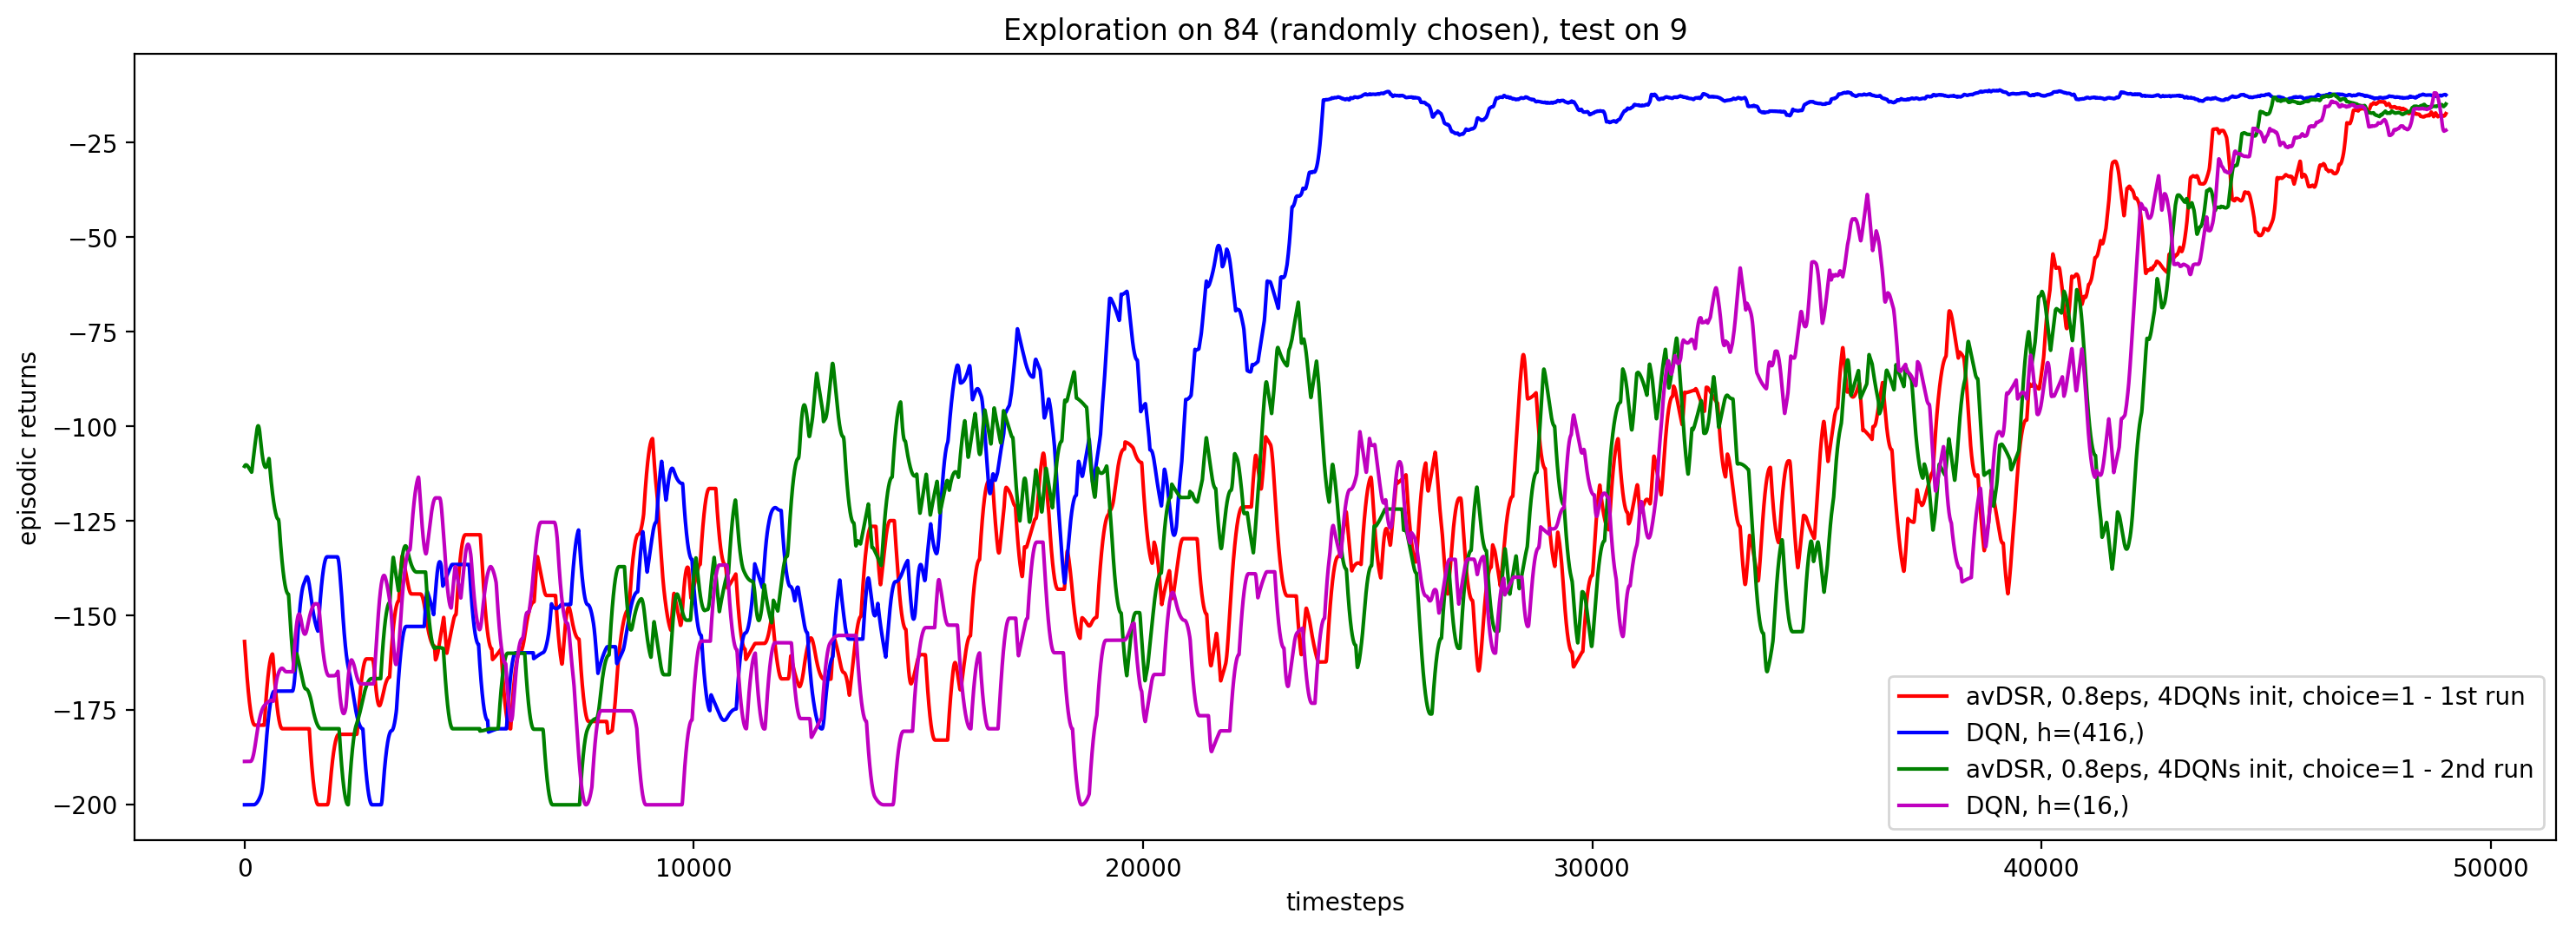

In [38]:
rewards_dict = {\
#                 'avDSR, 0.8eps, 1choice (4 DQNs init)':r_dsr_init_dqns_4rooms_c1,
#                 'avDSR, 0.8eps, 0choice (4 DQNs init)':r_dsr_init_dqns_4rooms_c0,
#                 'OOD: avDSR, 0.8eps, 0choice (3DQNs init)': r_dsr_init_ood_c0,
                'avDSR, 0.8eps, 4DQNs init, choice=1 - 1st run':r_dsr_init_rand,
                'DQN, h=(416,)': r_dqn_base,
                'avDSR, 0.8eps, 4DQNs init, choice=1 - 2nd run':r_dsr_init_dqns,
               'DQN, h=(16,)': r_dqn_base2}
# plot_rewards(rewards_dict, plot_seperate=True)
plot_rewards(rewards_dict, plot_seperate=False, title='Exploration on 84 (randomly chosen), test on 9')

Text(0.5,1,'goal = 84')

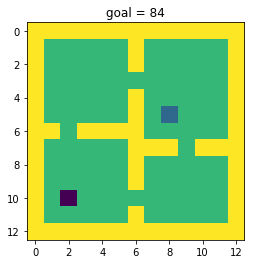

In [31]:
from deep_rl.component.fourrooms import FourRooms
env = FourRooms(goal=84)
state = env.reset()
plt.imshow(env.render())
plt.title('goal = ' + str(env.goal))

(104, 2)


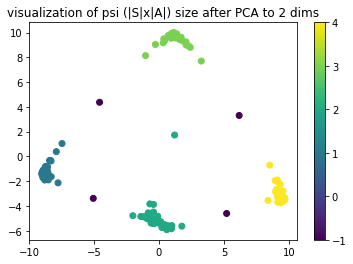

In [106]:
from sklearn.decomposition import PCA

def dimenRed(vis_agent):
    """
    Function to reduce the dimensionality of the psi(s,a) representations learnt,
    and visualizing them.
    """
    state_space = np.identity(104)
    c = np.ones(104)*4
    room1 = list(range(5)) + list(range(10,15)) + list(range(20,25)) + list(range(31,36)) +list(range(41,46))
    room2 = list(range(5,10)) + list(range(15,20)) + list(range(26,31)) + list(range(36,41)) + list(range(46,51)) + list(range(52,57))
    room3 = list(range(57,62)) + list(range(63,68)) + list(range(73,78)) + list(range(83,88)) + list(range(94,99))
    connect = [25, 51, 62, 88]
    c[room1] = 1
    c[room2] = 2
    c[room3] = 3
    c[connect] = [-1, -1, -1, -1]
    
    _, psi, _ = vis_agent.network(tensor(state_space))
    psi = psi.view(104,-1).detach().numpy()
    pca = PCA(n_components=2)
    k = pca.fit_transform(psi)
    print(k.shape)
    plt.scatter(k[:,0],k[:,1],c=c)
    plt.colorbar()
    plt.title('visualization of psi (|S|x|A|) size after PCA to 2 dims')
    
    
def dimenRed2(vis_agent, act_agent):
    """
    Function to reduce the dimensionality of the psi* representations learnt,
    and visualizing them.
    NOTE: psi*, where are the optimal actions picked from matters. act_agent 
    is used here.
    """
    state_space = np.identity(104)
    
    _, psi, _ = vis_agent.network(tensor(state_space))
    
    if('DSR' in str(type(act_agent))):
        _, _, q = act_agent.network(tensor(state_space))
    else:
        q = act_agent.network(tensor(state_space))
    optimal_actions = q.max(1)[1].detach().numpy()
    
    pass

dimenRed(avdsr)